# Lip Reading in TensorFlow

An attempt at using TensorFlow to analyse pixels in video files (without sound) of someone talking and produce an estimation of their speech.

I decided to use the GRID dataset, which has a good variety of speakers, although the sentence format is quite formulaic. Though this may result in a degree of overfitting, human speech is a very wide dataset and focusing on just one speaker and sentence format enabled me to create a more effective model.

The dataset can be downloaded here (speaker 20) -

https://spandh.dcs.shef.ac.uk/gridcorpus/

And I based my Neural Network on the one described in LipNet, which can be found here -

https://arxiv.org/pdf/1611.01599



In [65]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from typing import List
from typing import Tuple

from keras.models import Sequential
from keras.initializers import Orthogonal
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

In [66]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [67]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully")
else:
    print("No GPU found, using CPU")

GPU configured successfully


# Data Loading and Preprocessing

In [68]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []   # create frames array
    for _ in range(50):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame) # grayscale
        frames.append(frame[200:246,110:250,:]) # take only mouth portion (see below for matplotlib visualisation of frames)
                                               # i just used trial + error to find the right cutout
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std # calculate mean and std deviation and scale image

Conversion functions taken from
https://keras.io/examples/audio/ctc_asr/

In [69]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

char_to_num = tf.keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [70]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':  # all lines that are not "silence"
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
     # add to tokens array as numbers (using conversion function)

In [71]:
import os

def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('.', 's20vids', f'{file_name}.mpg')
    alignment_path = os.path.join('.', 'align', f'{file_name}.align')
    
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment file not found: {alignment_path}")
    
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [72]:
testing = './s20vids/bbwk7p.mpg'

In [73]:
with tf.device('/CPU:0'):
    print(load_data(tf.convert_to_tensor(testing))) # this returns the frames and alignments, ready for the NN
                                      # note the shape

(<tf.Tensor: shape=(50, 46, 140, 1), dtype=float32, numpy=
array([[[[0.18361138],
         [6.5837793 ],
         [6.3477073 ],
         ...,
         [5.37719   ],
         [5.32473   ],
         [5.534571  ]],

        [[0.15738118],
         [6.5837793 ],
         [6.3477073 ],
         ...,
         [5.37719   ],
         [5.32473   ],
         [5.534571  ]],

        [[0.15738118],
         [6.5837793 ],
         [6.3477073 ],
         ...,
         [5.37719   ],
         [5.32473   ],
         [5.534571  ]],

        ...,

        [[6.4788585 ],
         [6.4788585 ],
         [6.5313187 ],
         ...,
         [5.4034204 ],
         [5.37719   ],
         [5.5608015 ]],

        [[6.557549  ],
         [6.5313187 ],
         [6.5313187 ],
         ...,
         [5.4034204 ],
         [5.37719   ],
         [5.5608015 ]],

        [[6.557549  ],
         [6.557549  ],
         [6.4788585 ],
         ...,
         [5.4034204 ],
         [5.4034204 ],
         [5.587032  ]]],


 

In [74]:
def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
      result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
      return result #format data for tensorflow

### Using MatPlotLib to visualise frames

As you can see, MPL can be used to show what the NN sees. I used this (and trial + error on as many clips as I had patience for ) to center the mouth in the image, as this is the only part of the face we are interested in.

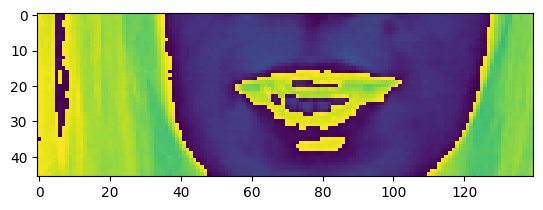

In [75]:
with tf.device('/CPU:0'):   
    frames, alignments = load_data(tf.convert_to_tensor(testing))
    plt.imshow(frames[34])

In [76]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with k seven please'>

# Data Pipeline

In [77]:
def create_dataset_from_videos(directory):
    # List all video files in the directory
    video_files = glob.glob(os.path.join(directory, '*.mpg'))
    
    # Validate that video files are found
    if not video_files:
        raise FileNotFoundError(f"No video files found in directory: {directory}")
    
    # Convert file paths to Unix-style paths
    video_files = [file.replace('\\', '/') for file in video_files]
    
    # Print the list of video files found
    print(f"Found {len(video_files)} video files")
    
    # Create a TensorFlow dataset from the list of video files
    dataset = tf.data.Dataset.from_tensor_slices(video_files)
    
    # Validate that the dataset is created correctly
    for file in dataset.take(5):
        print(f"Dataset file: {file.numpy().decode('utf-8')}")
    
    return dataset
# Usage
data = create_dataset_from_videos('./s20vids')
data = data.shuffle(999, reshuffle_each_iteration=False)  # shuffle them
data = data.map(mappable_function)   # use function to map them to TF format

 # setting data batches, 2 vids of 50 frames, 40 tokens
data = data.padded_batch(4, padded_shapes=([50,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)


 # split into training and test data
train = data.take(200)
test = data.skip(950)

Found 999 video files
Dataset file: ./s20vids/bbad3n.mpg
Dataset file: ./s20vids/bbad4s.mpg
Dataset file: ./s20vids/bbad5p.mpg
Dataset file: ./s20vids/bbad6a.mpg
Dataset file: ./s20vids/bbaj7n.mpg


In [79]:
with tf.device('/CPU:0'):    
    frames, alignments = data.as_numpy_iterator().next()

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} UnknownError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sub]
Traceback (most recent call last):

  File "c:\Users\notal\miniconda3\envs\lipreading\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "c:\Users\notal\miniconda3\envs\lipreading\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "c:\Users\notal\miniconda3\envs\lipreading\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "c:\Users\notal\miniconda3\envs\lipreading\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\notal\AppData\Local\Temp\ipykernel_13560\3292283078.py", line 14, in load_data
    frames = load_video(video_path)

  File "C:\Users\notal\AppData\Local\Temp\ipykernel_13560\1016885618.py", line 14, in load_video
    return tf.cast((frames - mean), tf.float32) / std # calculate mean and std deviation and scale image

  File "c:\Users\notal\miniconda3\envs\lipreading\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "c:\Users\notal\miniconda3\envs\lipreading\lib\site-packages\tensorflow\python\framework\ops.py", line 7209, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.UnknownError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sub]


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [15]:
test = data.as_numpy_iterator()

In [49]:
val = test.next(); val[0]

AttributeError: 'SkipDataset' object has no attribute 'next'

Visualisation of video

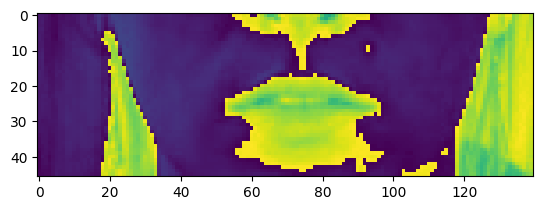

In [17]:
plt.imshow(val[0][0][6])  # 0 for frames not alignments, 0 for video one of two, 6 for frame 6

Transcript of video

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by d nine now'>

# Deep Learning

##Building the NN

In [ ]:

model = Sequential()

# First Conv3D Layer
model.add(Conv3D(128, 3, input_shape=(50, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After First Conv3D: {model.output_shape}")

# Second Conv3D Layer
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After Second Conv3D: {model.output_shape}")

# Third Conv3D Layer
model.add(Conv3D(50, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After Third Conv3D: {model.output_shape}")

# TimeDistributed Flatten Layer
model.add(TimeDistributed(Flatten()))
print(f"After TimeDistributed Flatten: {model.output_shape}")

# First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True)))
print(f"After First Bidirectional LSTM: {model.output_shape}")
model.add(Dropout(.5))

# Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, kernel_initializer= Orthogonal(), return_sequences=True)))
print(f"After Second Bidirectional LSTM: {model.output_shape}")
model.add(Dropout(.5))

# Dense Layer
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))
print(f"After Dense Layer: {model.output_shape}")


After First Conv3D: (None, 50, 23, 70, 128)
After Second Conv3D: (None, 50, 11, 35, 256)
After Third Conv3D: (None, 50, 5, 17, 50)
After TimeDistributed Flatten: (None, 50, 4250)
After First Bidirectional LSTM: (None, 50, 256)
After Second Bidirectional LSTM: (None, 50, 256)
After Dense Layer: (None, 50, 41)


In [20]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 50, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 50, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 50, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 50, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 50, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 50, 11, 35, 256)  0         
 3D)                                                    

###Untrained prediction

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'illrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr44'>

As you can see, not a very succesful prediction

###Learning Rate and Loss Function

In [23]:
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [24]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [25]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [50,50], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [26]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss=CTCLoss)

In [27]:
checkpoint_path = os.path.join('/content/drive/My Drive/Colab Notebooks/savedmodels','lipcheckpoint.weights.h5')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', save_best_only=True, save_weights_only=True)

In [28]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
for batch in train.take(1):  # Take a single batch for debugging
    x_input, y_true = batch
    y_pred = model(x_input, training=False)
    print("Predictions (y_pred):", y_pred.numpy())  # Inspect predictions

    # Check if y_pred sums to 1 along the last axis (softmax verification)
    softmax_check = tf.reduce_sum(y_pred, axis=-1)
    print("Softmax sum along the last axis (should be 1):", softmax_check.numpy())
    
    # Check for zero probabilities in y_pred
    zero_probs = tf.reduce_any(y_pred == 0, axis=-1)
    if tf.reduce_any(zero_probs):
        print("Found zero probabilities in y_pred!")
    else:
        print("No zero probabilities found in y_pred.")

    # Debugging CTCLoss inputs
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")  # Batch size
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")  # Time steps of y_pred
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")  # True label sequence length

    print("Batch length:", batch_len.numpy())
    print("Input length (should match y_pred time steps):", input_length.numpy())
    print("Label length (should match label sequence lengths):", label_length.numpy())

    # Check if label_length <= input_length for all samples
    if tf.reduce_any(label_length > input_length):
        print("Error: Found label_length > input_length!")
    else:
        print("All label lengths are valid.")

    # Compute the loss value for the batch
    loss_value = CTCLoss(y_true, y_pred)
    print("Loss value for batch:", loss_value.numpy())

Predictions (y_pred): [[[0.02717535 0.02167123 0.02666856 ... 0.02591068 0.02288024 0.02177408]
  [0.02824172 0.02103098 0.02527788 ... 0.02801636 0.02167093 0.02152019]
  [0.02899916 0.02066636 0.02391569 ... 0.02956331 0.02075588 0.02144182]
  ...
  [0.02443854 0.02267385 0.01808587 ... 0.03242362 0.02085231 0.02236978]
  [0.02423606 0.02320354 0.0179151  ... 0.03145773 0.02184174 0.02261932]
  [0.02391824 0.02383412 0.0179778  ... 0.0300527  0.02331329 0.02302106]]

 [[0.02644172 0.02204218 0.02687236 ... 0.02715197 0.02282544 0.02178492]
  [0.02767215 0.02130296 0.02510599 ... 0.02960268 0.02159065 0.02160343]
  [0.02859234 0.02096841 0.0233183  ... 0.03158795 0.02062846 0.02166313]
  ...
  [0.02452207 0.02395954 0.01802751 ... 0.03233388 0.02091901 0.02349279]
  [0.02432618 0.02435618 0.01797505 ... 0.03094592 0.02201428 0.02371645]
  [0.02404596 0.02476877 0.01820518 ... 0.02952365 0.02356457 0.02398893]]

 [[0.02619412 0.02406708 0.02519003 ... 0.02502733 0.02302188 0.02202947]


In [30]:
example_callback = ProduceExample(train)

: 

In [ ]:
model.fit(train, validation_data=test, epochs = 5, callbacks=[schedule_callback, example_callback])

Epoch 1/5
